In [1]:
from typing import List, Optional, Union, Callable, Tuple

import geopandas as gpd
import numpy as np
from scipy.optimize import linear_sum_assignment
from shapely.geometry import Polygon

from tree_detection_framework.constants import DATA_FOLDER
from tree_detection_framework.detection.region_detections import RegionDetectionsSet
from tree_detection_framework.detection.detector import GeometricTreeTopDetector
from tree_detection_framework.preprocessing.preprocessing import create_dataloader
from tree_detection_framework.postprocessing.postprocessing import (
    remove_edge_detections,
    suppress_tile_boundary_with_NMS,
    multi_region_NMS,
)

from scipy.spatial import KDTree

/home/aspallav/miniconda3/envs/tdf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/aspallav/miniconda3/envs/tdf/lib/python3.10/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.2'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
CHM_FILE = DATA_FOLDER / "emerald-point/raster-data/chm.tif"
ORTHO_FILE = DATA_FOLDER / "emerald-point/raster-data/ortho.tif"

In [3]:
dataloader = create_dataloader(CHM_FILE, chip_size=500, chip_stride=250, resolution=0.2)

INFO:root:Units = Units.PIXELS
INFO:root:Stride = 250


Performing prediction on batches: 100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


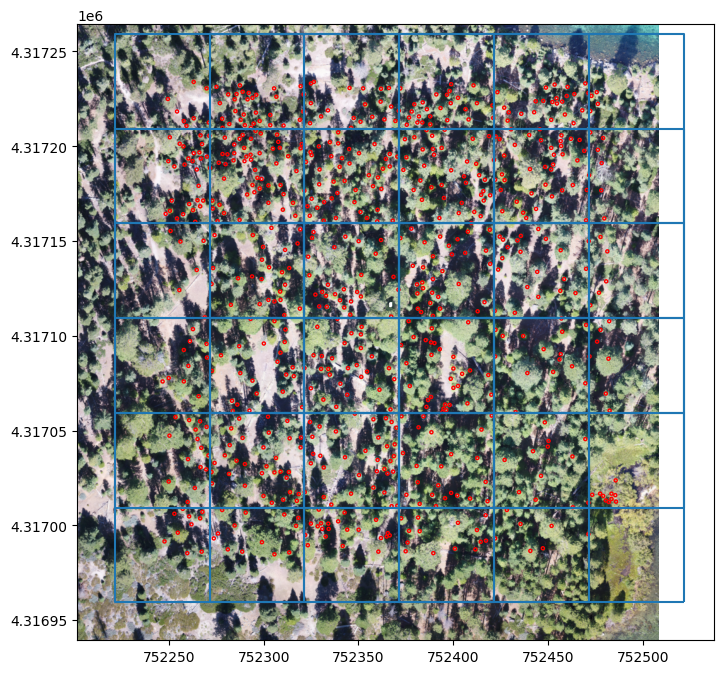

<Axes: >

In [4]:
treetop_detector = GeometricTreeTopDetector(a=0.0045, c=1)
treetop_set_1 = treetop_detector.predict(dataloader)

# Remove the tree tops that were generated in the edges of tiles. This is an alternative to NMS.
treetop_set_1 = remove_edge_detections(
    treetop_set_1,
    suppression_distance=(500 - 250) * 0.2 / 2,
)

treetop_set_1.plot(detection_kwargs = {
    "markersize": 20,
    "marker": ".",
    "color": "red",
}, raster_file=ORTHO_FILE)

Performing prediction on batches: 100%|██████████| 25/25 [00:10<00:00,  2.43it/s]


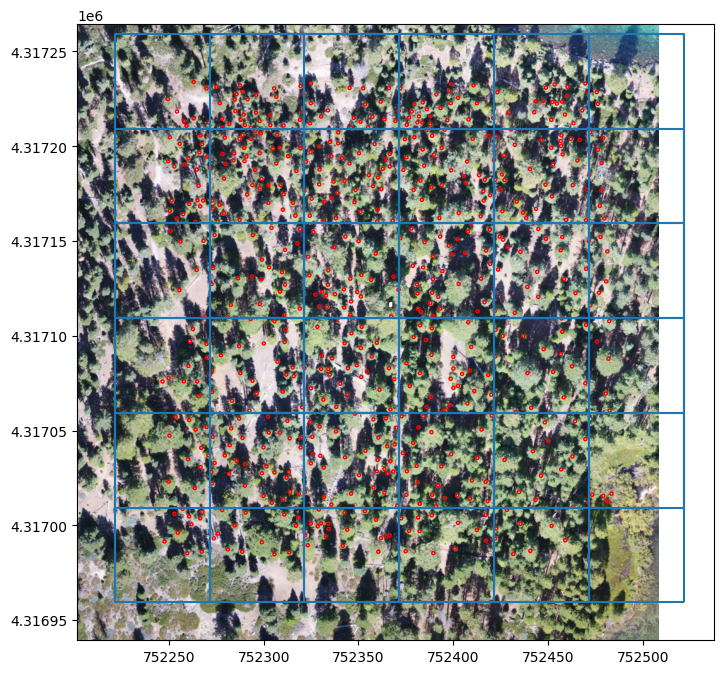

<Axes: >

In [5]:
treetop_detector = GeometricTreeTopDetector(a=0.0020, b=0.05, c=1.2)
treetop_set_2 = treetop_detector.predict(dataloader)

# Remove the tree tops that were generated in the edges of tiles. This is an alternative to NMS.
treetop_set_2 = remove_edge_detections(
    treetop_set_2,
    suppression_distance=(500 - 250) * 0.2 / 2,
)

treetop_set_2.plot(detection_kwargs = {
    "markersize": 20,
    "marker": ".",
    "color": "red",
}, raster_file=ORTHO_FILE)

In [6]:
merged_treetop_set_1 = treetop_set_1.merge()
merged_treetop_set_1.get_data_frame()

,height,score,geometry,region_ID,unique_ID
0,15.873573,126.0,POINT (752285.69 4317034.099),0,00000
1,21.599489,132.0,POINT (752274.09 4317032.899),0,00001
2,18.213995,135.0,POINT (752290.09 4317032.299),0,00002
3,6.408730,143.0,POINT (752266.69 4317030.699),0,00003
4,5.179368,149.0,POINT (752269.69 4317029.499),0,00004
...,...,...,...,...,...
730,44.387287,159.0,POINT (752478.29 4317191.099),24,00730
731,15.743649,155.0,POINT (752452.69 4317190.299),24,00731
732,8.689607,135.0,POINT (752448.49 4317189.099),24,00732
733,8.310930,142.0,POINT (752451.69 4317187.699),24,00733


In [7]:
merged_treetop_set_2 = treetop_set_2.merge()
merged_treetop_set_2.get_data_frame()

,height,score,geometry,region_ID,unique_ID
0,15.873573,126.0,POINT (752285.69 4317034.099),0,00000
1,21.599489,132.0,POINT (752274.09 4317032.899),0,00001
2,18.213995,135.0,POINT (752290.09 4317032.299),0,00002
3,6.408730,143.0,POINT (752266.69 4317030.699),0,00003
4,14.908995,156.0,POINT (752272.49 4317028.099),0,00004
...,...,...,...,...,...
650,24.222696,181.0,POINT (752457.69 4317195.699),24,00650
651,33.964771,166.0,POINT (752465.49 4317192.499),24,00651
652,44.387287,159.0,POINT (752478.29 4317191.099),24,00652
653,15.743649,155.0,POINT (752452.69 4317190.299),24,00653


In [8]:
merged_treetop_set_1 = treetop_set_1.get_data_frame(merge=True)
merged_treetop_set_2 = treetop_set_2.get_data_frame(merge=True)
treetop_points_1 = merged_treetop_set_1.geometry
treetop_points_2 = merged_treetop_set_2.geometry
coords1 = np.array([[pt.x, pt.y] for pt in treetop_points_1])
coords2 = np.array([[pt.x, pt.y] for pt in treetop_points_2])

In [9]:
coords2

array([[ 752285.69032156, 4317034.0987619 ],
       [ 752274.09032156, 4317032.8987619 ],
       [ 752290.09032156, 4317032.2987619 ],
       ...,
       [ 752478.29032156, 4317191.0987619 ],
       [ 752452.69032156, 4317190.2987619 ],
       [ 752471.69032156, 4317184.6987619 ]], shape=(655, 2))

In [10]:
height1 = merged_treetop_set_1['height'].values
height2 = merged_treetop_set_2['height'].values

In [11]:
# Build search tree on set_2 (the targets)
tree2 = KDTree(coords2)
matched = []
used_2 = set()

In [13]:
distance_threshold =10
for i, (pt1, h1) in enumerate(zip(coords1, height1)):
    dist_thresh = distance_threshold(h1) if callable(distance_threshold) else distance_threshold
    idxs = tree2.query_ball_point(pt1, dist_thresh)
    candidates = []
    print(idxs)
    break


[148, 5, 145, 0, 2]


In [ ]:
def match_points(
    treetop_set_1: RegionDetectionsSet,
    treetop_set_2: RegionDetectionsSet,
    height1: Optional[Union[str, np.ndarray]],
    height2: Optional[Union[str, np.ndarray]],
    chm: Optional[np.ndarray] = None,
    bboxes: Optional[gpd.GeoDataFrame] = None,
    distance_threshold: Union[float, Callable[[float], float]] = 10.0,
    height_abs_threshold: Optional[float] = None,
    height_fraction_threshold: Optional[float] = None,
    fillin_method: Optional[str] = None  # "chm", "bbox", or "other"
) -> List[Tuple[int, int, np.ndarray]]:
    # check for meters based CRS and that it's the same. get_projected_CRS()
    merged_treetop_set_1 = treetop_set_1.get_data_frame(merge=True)
    merged_treetop_set_2 = treetop_set_2.get_data_frame(merge=True)
    treetop_points_1 = merged_treetop_set_1.geometry
    treetop_points_2 = merged_treetop_set_2.geometry
    coords1 = np.array([[pt.x, pt.y] for pt in treetop_points_1])
    coords2 = np.array([[pt.x, pt.y] for pt in treetop_points_2])
    
    # check that both have height col
    if isinstance(height1, str) and isinstance(height2, str):
        height1 = merged_treetop_set_1[height1].values
        height2 = merged_treetop_set_2[height2].values

    # if height1 is None and height2 is None:
    #     height1 = fill_heights(treetop_set_1, chm, bboxes, method=fillin_method)
    #     height2 = fill_heights(treetop_set_2, chm, bboxes, method=fillin_method)
    
    # Build search tree on set_2 (the targets)
    tree2 = KDTree(coords2)
    matched = []
    # Keep track of matched points in set_2 to avoid multiple matches
    used_2 = set()
    
    # For each point in set_1 find the best available point in set_2
    for i, (pt1, h1) in enumerate(zip(coords1, height1)):
        # Determine the distance threshold based on height or use a fixed threshold
        dist_thresh = distance_threshold(h1) if callable(distance_threshold) else distance_threshold
        # Find all points in set_2 that are within dist_thresh distance from pt1
        candidate_indices = tree2.query_ball_point(pt1, dist_thresh)
        candidates = []
        
        # Filter the candidate points
        for j in candidate_indices:
            # Skip if this point in set_2 has already been used
            if j in used_2:
                continue
            
            # skip if height difference is more than threshold
            h2 = height2[j]
            height_diff = abs(h1 - h2)
            # Height filtering
            if height_abs_threshold is not None and height_diff > height_abs_threshold:
                continue

            distance = np.linalg.norm(pt1 - coords2[j])
            candidates.append((j, distance, np.array([distance, height_diff])))
        
        if candidates:
            # Select the candidate with the minimum distance as the best match
            j_best, _, distance_height = min(candidates, key=lambda x: x[1])
            matched.append((i, j_best, distance_height))
            used_2.add(j_best)
    
    return matched

In [ ]:
# Pr: num of matches / num of preds
# Recall: num of matches / num of gt trees

In [28]:
matched = match_points(
    treetop_set_1,
    treetop_set_2,
    height1="height",
    height2="height",
)

In [29]:
matched

[(0, 0, array([0., 0.])),
 (1, 1, array([0., 0.])),
 (2, 2, array([0., 0.])),
 (3, 3, array([0., 0.])),
 (4, 4, array([3.13049517, 9.72962666])),
 (5, 7, array([6.00333241, 6.54177284])),
 (6, 5, array([0., 0.])),
 (7, 6, array([0., 0.])),
 (8, 9, array([ 9.31450482, 12.99934769])),
 (9, 8, array([0., 0.])),
 (11, 10, array([4.44072066, 9.20809937])),
 (12, 14, array([5.11077294, 8.48695755])),
 (13, 11, array([0., 0.])),
 (14, 12, array([0., 0.])),
 (15, 13, array([0., 0.])),
 (16, 15, array([7.9246451 , 9.01746368])),
 (17, 17, array([4.36806593, 0.14162254])),
 (18, 16, array([0., 0.])),
 (19, 19, array([ 8.43800924, 14.17931938])),
 (20, 18, array([0., 0.])),
 (21, 22, array([ 8.37615664, 11.27278137])),
 (22, 20, array([0., 0.])),
 (23, 21, array([0., 0.])),
 (25, 23, array([0., 0.])),
 (26, 24, array([0., 0.])),
 (27, 25, array([0., 0.])),
 (28, 26, array([0., 0.])),
 (29, 27, array([0., 0.])),
 (30, 28, array([0., 0.])),
 (31, 29, array([0., 0.])),
 (32, 31, array([ 3.2249031 , 

In [ ]:
from scipy.spatial.distance import cdist

distance_matrix = cdist(coords1, coords2, metric='euclidean')
distance_matrix

In [75]:
for i, (pt1, ht1) in enumerate(zip(coords1, height1)):
    # distances to points in set 2
    dist_set_2 = distance_matrix[i]
    # find the index of the closest point in set 2
    closest_index = np.argmin(dist_set_2)
    # distance_matrix[i, closest_index] has the distance between the potential match
    if isinstance(distance_cutoff, Callable):
        distance_cutoff_value = distance_cutoff(h1, height2[closest_index])
    else:
        # it's a fixed value
        distance_cutoff_value = distance_cutoff
    if dist_set_2[closest_index] < distance_cutoff_value:
        # this is a match
        matched_pairs.append((i, closest_index))
    

0.0
0.0
0.0
0.0
3.130495168707956
0.0
0.0
0.0
0.0
0.0
0.0
4.44072066191927
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.224903099434936
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.7363083389922886
0.0
0.0
0.0
0.0
0.0
0.0
5.336665625760477
0.0
0.0
0.0
0.0
0.0
2.778488798097779
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.006659275686972
0.0
0.0
0.0
0.0
6.0
0.0
0.0
1.5620499346089616
0.0
0.0
0.0
4.707440918011901
0.0
0.0
0.0
0.0
0.0
0.0
3.492849839047959
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.8635642126227476
0.0
7.247068372632882
0.0
7.337574531123695
2.000000000093132
0.0
0.0
2.1540659231305095
0.0
2.126029162281905
0.0
3.8052595181443816
0.0
0.0
0.0
0.0
0.0
6.746851117348354
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.440930106760212
0.0
5.249761899377754
0.0
0.0
0.0
4.534313619519312
0.0
0.0
0.0
0.0
0.0
5.015974482106234
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
